In [63]:
!pip install --user --upgrade apafib


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [64]:
from apafib import load_travel_review
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report, \
                    precision_recall_fscore_support, roc_auc_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.linear_model._logistic")
from yellowbrick.classifier.rocauc import roc_auc
from sklearn.linear_model import LogisticRegression

In [65]:
df = load_travel_review()
print("Columnas del DataFrame:")
print(df.columns.tolist())


Columnas del DataFrame:
['art galleries', 'dance clubs', 'juice bars', 'restaurants', 'museums', 'resorts', 'parks/picnic spots', 'beaches', 'theaters', 'religious institutions', 'class']


In [66]:
target_col = 'class'
X = df.drop(columns=[target_col])
y = df[target_col]
print("Shapes -> df:", df.shape, "| X:", X.shape, "| y:", y.shape)
print(df.head())

Shapes -> df: (980, 11) | X: (980, 10) | y: (980,)
   art galleries  dance clubs  juice bars  restaurants  museums  resorts  \
0           0.93          1.8        2.29         0.62     0.80     2.42   
1           1.02          2.2        2.66         0.64     1.42     3.18   
2           1.22          0.8        0.54         0.53     0.24     1.54   
3           0.45          1.8        0.29         0.57     0.46     1.52   
4           0.51          1.2        1.18         0.57     1.54     2.02   

   parks/picnic spots  beaches  theaters  religious institutions  class  
0                3.19     2.79      1.82                    2.42      1  
1                3.21     2.63      1.86                    2.32      1  
2                3.18     2.80      1.31                    2.50      3  
3                3.18     2.96      1.57                    2.86      2  
4                3.18     2.78      1.18                    2.54      2  


In [67]:
df.isna().sum()

art galleries             0
dance clubs               0
juice bars                0
restaurants               0
museums                   0
resorts                   0
parks/picnic spots        0
beaches                   0
theaters                  0
religious institutions    0
class                     0
dtype: int64

In [68]:
sum(df.isna().sum())

0

# Apartado A

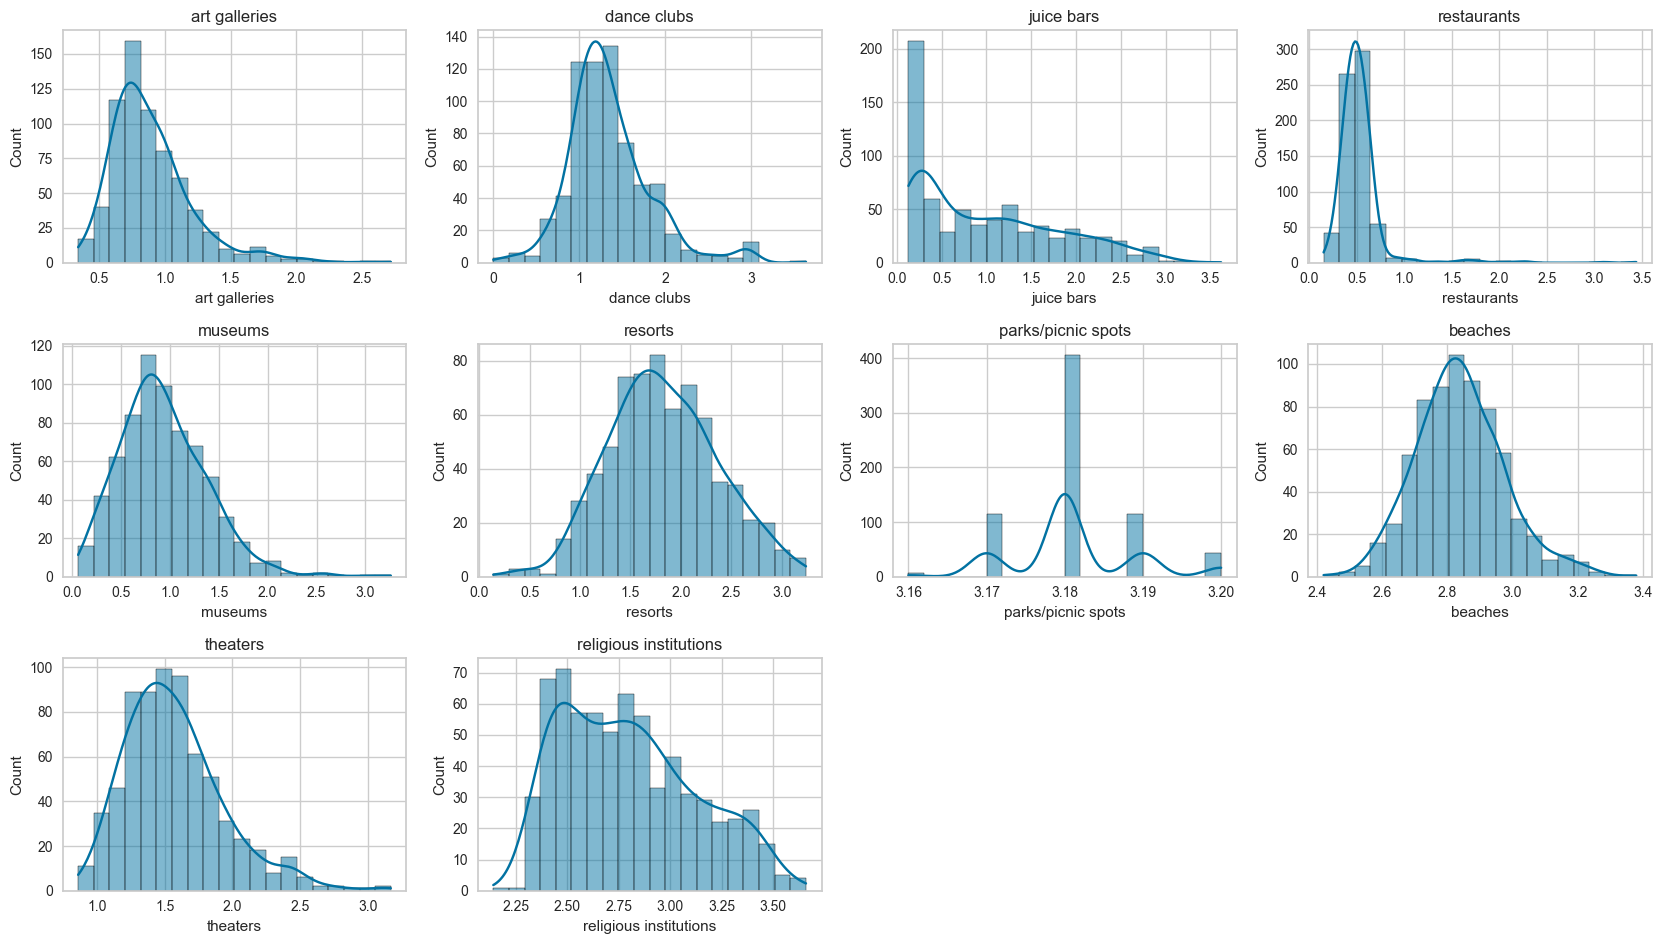

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

n_cols = 4
n_vars = X_train.shape[1]
n_rows = int(np.ceil(n_vars / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.2*n_cols, 3.2*n_rows))
axes = axes.ravel()

for i, col in enumerate(X_train.columns):
    sns.histplot(X_train[col], ax=axes[i], bins=20, kde=True)
    axes[i].set_title(col)
for j in range(i+1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

Vemos que los datos que nos provienen tienen el suficiente significado y sentido, ya que al ser promedios es muy dificil que alguna categoria este en mínimos o máximos (0 y 4). 

Varias categorias muestran una simetría positiva, con colas hacia la derecha, como art galleries, museums, restaurants, juice bars y theaters, lo que nos indica que muchos usuarios puntúan en rangos más bien bajos o medios. En cambio resorts y sobre todo beaches se aproximan más a una distribución gaussiana.

También podemos ver que la categoria "park/picnic spots" tiene muy poca variación, por lo cuál es candidata a ser poco informativa.

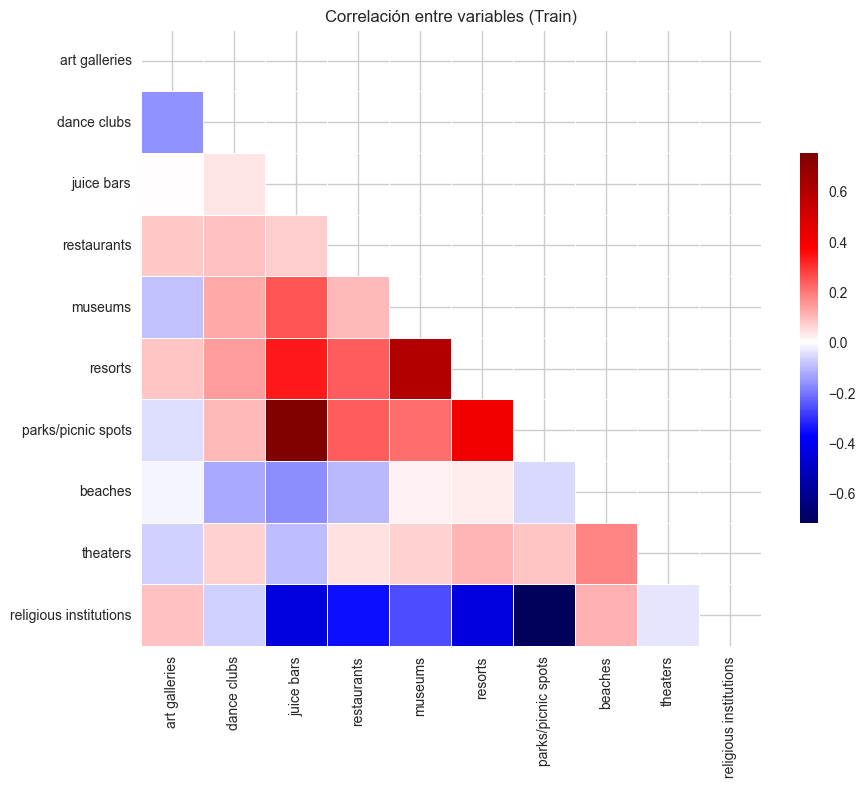

In [70]:
corr = X_train.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic', center=0, linewidths=.5, cbar_kws={'shrink': .6})
plt.title('Correlación entre variables (Train)')
plt.show()

La matriz de correlación revela dependencias entre atributos, como por ejemplo resorts con museums o juice bars y una relación negativa consistente entre religious institutions con actividades de ocio.

El histograma y el mapa de correlaciones nos confirma que las variables si son continuas y al ser promedios en escala de 0 a 4, apenas muestran saturación en los extremos. Además, varias variables muestran asimetría de la normalidad, lo que nos indica que no son gaussianas.

## División del conjunto de datos: Variables originales vs Variables gaussianas

Vamos a dividir el conjunto de datos, uno con las variables originales sin modificar nada y otro modificando las variables que se desvían bastante de la gausianidad, para que todas las variables del conjunto sean variables razonablemente gaussianas. Utilizaremos el método QuantileTransformer de scikit-learn. 

In [71]:
stats_df = pd.DataFrame({'skew': X_train.skew(numeric_only=True),'kurtosis': X_train.kurtosis(numeric_only=True)})
non_gaussian_cols = stats_df[(stats_df['skew'].abs() > 1) | (stats_df['kurtosis'].abs() > 3)].index.tolist()


In [72]:
X_train_orig = X_train.copy()
X_test_orig  = X_test.copy()

X_train_trans = X_train.copy()
X_test_trans  = X_test.copy()

qt = QuantileTransformer(output_distribution='normal', random_state=42,n_quantiles=min(1000, len(X_train_trans)))
X_train_trans[non_gaussian_cols] = qt.fit_transform(X_train_trans[non_gaussian_cols])
X_test_trans[non_gaussian_cols]  = qt.transform(X_test_trans[non_gaussian_cols])

In [73]:
scaler_orig = StandardScaler()
X_train_orig_s = pd.DataFrame(scaler_orig.fit_transform(X_train_orig), columns=X_train_orig.columns, index=X_train_orig.index)

X_test_orig_s = pd.DataFrame(scaler_orig.transform(X_test_orig), columns=X_test_orig.columns, index=X_test_orig.index)

scaler_trans = StandardScaler()
X_train_trans_s = pd.DataFrame(scaler_trans.fit_transform(X_train_trans), columns=X_train_trans.columns, index=X_train_trans.index)
X_test_trans_s = pd.DataFrame(scaler_trans.transform(X_test_trans), columns=X_test_trans.columns, index=X_test_trans.index)

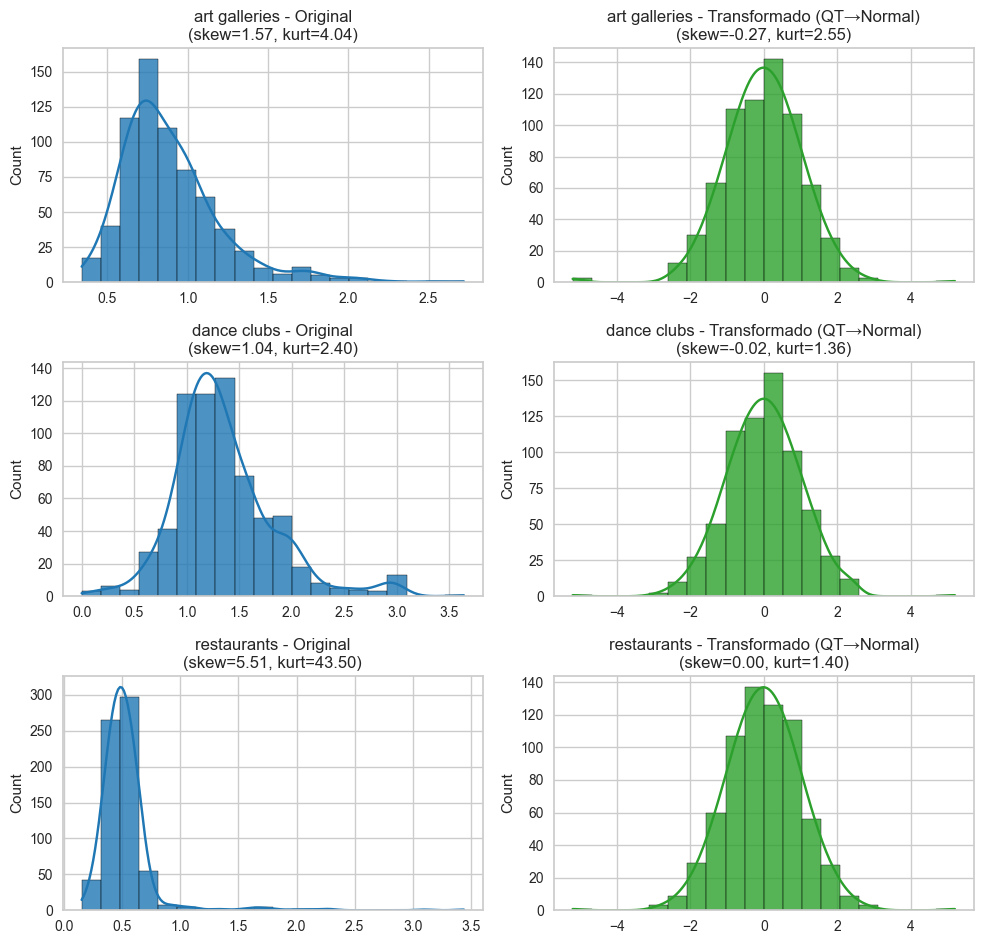

In [74]:
cols = non_gaussian_cols[:min(6, len(non_gaussian_cols))]
stats_before = X_train_orig[cols].agg(['skew', 'kurtosis']).T.rename(columns={'skew':'skew_before','kurtosis':'kurt_before'})
stats_after  = X_train_trans[cols].agg(['skew', 'kurtosis']).T.rename(columns={'skew':'skew_after','kurtosis':'kurt_after'})
stats_comp = stats_before.join(stats_after)
n = len(cols)
n_cols = 2
n_rows = n
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3.2*n), sharex=False)
if n_rows == 1:
    axes = [axes]  # normalizar a lista de filas

for i, c in enumerate(cols):
    # Original
    ax1 = axes[i][0] if n_rows > 1 else axes[0]
    sns.histplot(X_train_orig[c], bins=20, kde=True, ax=ax1, color='#1f77b4', alpha=0.8)
    ax1.set_title(f"{c} - Original\n(skew={stats_comp.loc[c,'skew_before']:.2f}, kurt={stats_comp.loc[c,'kurt_before']:.2f})")
    ax1.set_xlabel("")

    # Transformado
    ax2 = axes[i][1] if n_rows > 1 else axes[1]
    sns.histplot(X_train_trans[c], bins=20, kde=True, ax=ax2, color='#2ca02c', alpha=0.8)
    ax2.set_title(f"{c} - Transformado (QT→Normal)\n(skew={stats_comp.loc[c,'skew_after']:.2f}, kurt={stats_comp.loc[c,'kurt_after']:.2f})")
    ax2.set_xlabel("")

plt.tight_layout()
plt.show()

# Apartado B - Naive Bayes

In [75]:
def save_results(clf, X_test, y_test, nclf, df):
    if hasattr(clf, 'best_score_'):
        df.loc[nclf,'train XV acc'] = clf.best_score_
    else:
        df.loc[nclf,'train XV acc'] = np.nan
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (M)'] = precision_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'recall score (M)'] = recall_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'f1 score (M)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    return df

In [76]:
gnb_orig = GaussianNB()
gnb_trans = GaussianNB()

gnb_orig.best_score_ = np.mean(cross_val_score(gnb_orig, X_train_orig_s, y_train, cv=5))
gnb_trans.best_score_ = np.mean(cross_val_score(gnb_trans, X_train_trans_s, y_train, cv=5))

print(f"CV acc GaussianNB (Original):   {gnb_orig.best_score_:.4f}")
print(f"CV acc GaussianNB (Transform.): {gnb_trans.best_score_:.4f}")


CV acc GaussianNB (Original):   0.7318
CV acc GaussianNB (Transform.): 0.7594


A priori la transformación mejora en gaussianNB. 

In [77]:
gnb_orig_model = GaussianNB().fit(X_train_orig_s, y_train)
gnb_orig_model.best_score_ = gnb_orig.best_score_

gnb_trans_model = GaussianNB().fit(X_train_trans_s, y_train)
gnb_trans_model.best_score_ = gnb_trans.best_score_

# (Opcional) inspección de parámetros del modelo
print('Priors (orig):', np.round(gnb_orig_model.class_prior_, 4))
means_orig = pd.DataFrame(gnb_orig_model.theta_, columns=list(X_train_orig_s.columns))
print('Means (orig):')
display(means_orig.head())


Priors (orig): [0.2055 0.2595 0.2303 0.3047]
Means (orig):


,art galleries,dance clubs,juice bars,restaurants,museums,resorts,parks/picnic spots,beaches,theaters,religious institutions
0,0.095319,-0.354890,0.321529,-0.136313,-0.219246,-0.174011,0.016110,-0.007186,-0.236898,0.029263
1,0.036569,0.288353,1.065801,0.155401,0.620589,0.668015,0.903948,-0.249693,-0.011083,-0.707323
2,-0.031294,0.177671,-0.575640,0.295107,0.218760,0.396456,-0.297513,0.224582,0.129562,0.122278
3,-0.071794,-0.140475,-0.689459,-0.263484,-0.546006,-0.751250,-0.555824,0.047725,0.071314,0.490227


In [78]:
print('Priors (trans):', np.round(gnb_trans_model.class_prior_, 4))
means_trans = pd.DataFrame(gnb_trans_model.theta_, columns=list(X_train_trans_s.columns))
print('Means (trans):')
display(means_trans.head())

Priors (trans): [0.2055 0.2595 0.2303 0.3047]
Means (trans):


,art galleries,dance clubs,juice bars,restaurants,museums,resorts,parks/picnic spots,beaches,theaters,religious institutions
0,0.085152,-0.363667,0.321529,-0.141976,-0.219246,-0.174011,0.016110,-0.007186,-0.236898,0.029263
1,0.095589,0.265668,1.065801,0.396811,0.620589,0.668015,0.903948,-0.249693,-0.011083,-0.707323
2,-0.074788,0.147262,-0.575640,0.226056,0.218760,0.396456,-0.297513,0.224582,0.129562,0.122278
3,-0.082319,-0.092245,-0.689459,-0.413066,-0.546006,-0.751250,-0.555824,0.047725,0.071314,0.490227


Vemos que los Priors son idénticos, por lo que nos confirma que la transformación no ha tocado la distribución entre clases, solo las features. También vemos que no hay una clase mayoritaria, todas las clases representan más o menos una cantidad parecida de datos, por lo que F1 macro debería ser lo suficientemente explicativo.

Podemos observar que las categorias que ya tenian una distribución gaussiana (juice bars, resorts, parks/picnic spots, beaches, theaters, religious institutions) sus valores no cambian. En cambio en las que se tenía que gaussianizar (restaurants, art galleries, dance clubs, museums en menor medida) si muestran desplazamientos.

In [79]:
results_df = pd.DataFrame()

results_df = pd.DataFrame()

print("\nTest report: GaussianNB (Original) ==")
y_pred_orig = gnb_orig_model.predict(X_test_orig_s)
print(classification_report(y_test, y_pred_orig))
results_df = save_results(gnb_orig_model, X_test_orig_s, y_test, 'GNB (orig)', results_df)

print("\nTest report: GaussianNB (Transformado) ==")
y_pred_trans = gnb_trans_model.predict(X_test_trans_s)
print(classification_report(y_test, y_pred_trans))
results_df = save_results(gnb_trans_model, X_test_trans_s, y_test, 'GNB (trans)', results_df)

print("\nResultados acumulados:")
print(results_df)


Test report: GaussianNB (Original) ==
              precision    recall  f1-score   support

           0       0.55      0.65      0.60        60
           1       0.77      0.77      0.77        77
           2       0.79      0.50      0.61        68
           3       0.70      0.81      0.75        89

    accuracy                           0.69       294
   macro avg       0.70      0.68      0.68       294
weighted avg       0.71      0.69      0.69       294


Test report: GaussianNB (Transformado) ==
              precision    recall  f1-score   support

           0       0.71      0.58      0.64        60
           1       0.76      0.82      0.79        77
           2       0.75      0.72      0.74        68
           3       0.76      0.83      0.80        89

    accuracy                           0.75       294
   macro avg       0.75      0.74      0.74       294
weighted avg       0.75      0.75      0.75       294


Resultados acumulados:
             train XV ac

Tanto el Test accuracy como F1 macro aumentan considerablemente después de la transformación. No solo mejora el rendimiento sinó que también reduce el gap de generalilzación. 

Podemos ver también que la mejora del F1 macro y de los trade-offs viene dada casi todo por la mejora en la Clase 2 (F1 0.61 → 0.74, Recall 0.50 → 0.72), lo que nos indica que antes de la gaussanización las densidades de la clase 2 estaban mal estimadas.

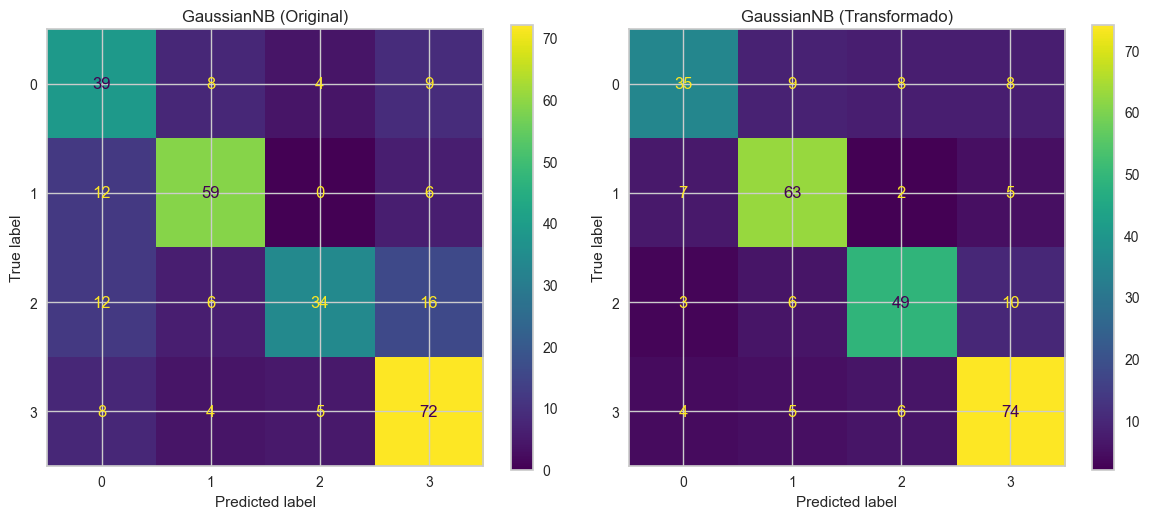

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_estimator(gnb_orig_model, X_test_orig_s, y_test, ax=ax[0])
ax[0].set_title('GaussianNB (Original)')
ConfusionMatrixDisplay.from_estimator(gnb_trans_model, X_test_trans_s, y_test, ax=ax[1])
ax[1].set_title('GaussianNB (Transformado)')
plt.tight_layout()
plt.show()

C:\Users\34656\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


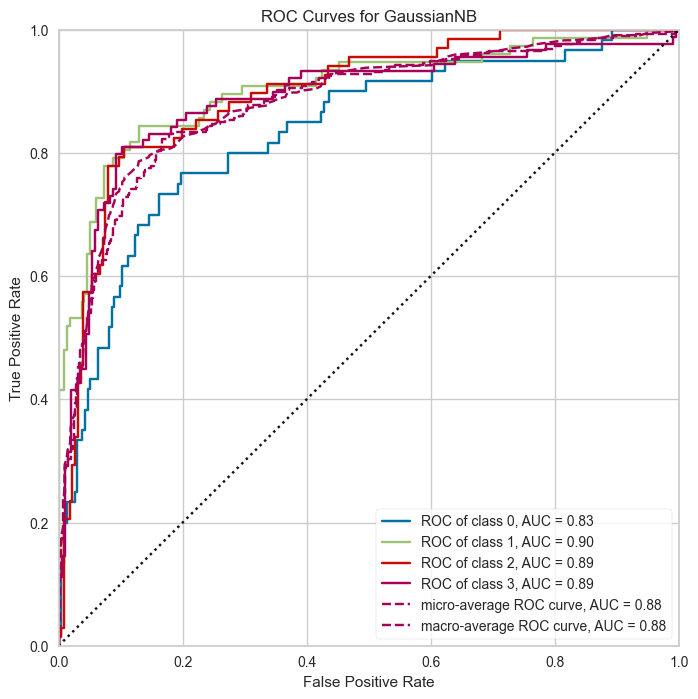

C:\Users\34656\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


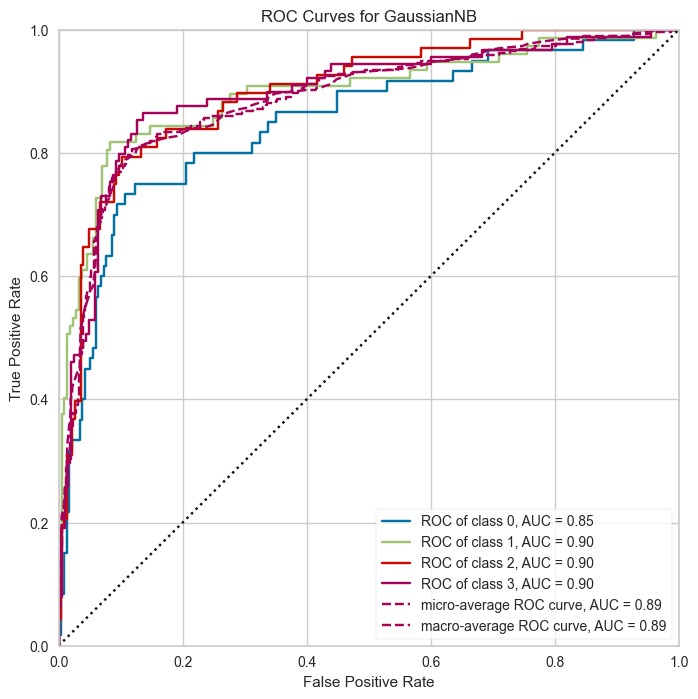

,estimator,GaussianNB()
,ax,<Axes: title=...ositive Rate'>
,micro,True
,macro,True
,per_class,True
,binary,False
,classes,"['0', '1', ...]"
,encoder,None
,is_fitted,'auto'
,force_model,False
,priors,None


In [81]:
cls = [str(v) for v in sorted(pd.Series(y_train).unique())]

plt.figure(figsize=(8, 8))
roc_auc(gnb_orig_model, X_train_orig_s, y_train, X_test_orig_s, y_test, classes=cls)

plt.figure(figsize=(8, 8))
roc_auc(gnb_trans_model, X_train_trans_s, y_train, X_test_trans_s, y_test, classes=cls)

Las curvas de ROC confirman el buen rendimiento en ambos modelos con una pequeña y consistente mejora después de la transformación. En conclusión, la gaussanización mejora el rendimiento del modelo y lo vemos en todas las métricas y curvas (suben la accuracy y el F1 macro en test, así como el AUC micro/macro y por clase), con un salto especialmente marcado en la clase 2 y una ligera mejora en la clase 0.

# Apartado C - LDA

In [82]:
lda_orig = LinearDiscriminantAnalysis()
lda_orig.best_score_ = np.mean(cross_val_score(lda_orig,X_train_orig_s,y_train,cv=10))
print(lda_orig.best_score_)

0.7595055413469736


In [83]:
lda_trans = LinearDiscriminantAnalysis()
lda_trans.best_score_ = np.mean(cross_val_score(lda_trans, X_train_trans_s, y_train, cv=10))
print(lda_trans.best_score_)

0.7595907928388747


In [84]:
n_classes = len(np.unique(y_train))
comp_list = [None] + list(range(1, n_classes))

param_grid = [
    {
        'solver': ['lsqr', 'eigen'],
        'shrinkage': [None, 'auto'],
        'n_components': comp_list
    },
    {
        'solver': ['svd'],
        'n_components': comp_list
    }
]

grid_lda_orig = GridSearchCV(LinearDiscriminantAnalysis(), param_grid, cv=10)
grid_lda_orig.fit(X_train_orig_s, y_train)
print("Best CV score (Original):", grid_lda_orig.best_score_)
print("Best params (Original):", grid_lda_orig.best_params_)

grid_lda_trans = GridSearchCV(LinearDiscriminantAnalysis(), param_grid, cv=10)
grid_lda_trans.fit(X_train_trans_s, y_train)
print("Best CV score (Transformado):", grid_lda_trans.best_score_)
print("Best params (Transformado):", grid_lda_trans.best_params_)

Best CV score (Original): 0.7712063086104006
Best params (Original): {'n_components': None, 'shrinkage': 'auto', 'solver': 'lsqr'}
Best CV score (Transformado): 0.7682438192668372
Best params (Transformado): {'n_components': None, 'shrinkage': 'auto', 'solver': 'lsqr'}


La búsqueda de hiper parámetros si aporta una pequeña mejora, sobre todo en el modelo original. Dada esta mejora, tiene sentido utilizar los best_params en el ajuste final. 

In [85]:
lda_model_orig = LinearDiscriminantAnalysis(**grid_lda_orig.best_params_).fit(X_train_orig_s, y_train)
lda_model_orig.best_score_ = grid_lda_orig.best_score_

lda_model_trans = LinearDiscriminantAnalysis(**grid_lda_trans.best_params_).fit(X_train_trans_s, y_train)
lda_model_trans.best_score_ = grid_lda_trans.best_score_

print("Priors (Original):", lda_model_orig.priors_)
print("Priors (Transformado):", lda_model_trans.priors_)



Priors (Original): [0.20553936 0.25947522 0.2303207  0.30466472]
Priors (Transformado): [0.20553936 0.25947522 0.2303207  0.30466472]


In [86]:
print("\nClassification report LDA (Original)")
print(classification_report(y_test, lda_model_orig.predict(X_test_orig_s)))
results_df = save_results(lda_model_orig, X_test_orig_s, y_test, 'LDA (orig)', results_df)

print("\nClassification report LDA (Transformado)")
print(classification_report(y_test, lda_model_trans.predict(X_test_trans_s)))
results_df = save_results(lda_model_trans, X_test_trans_s, y_test, 'LDA (trans)', results_df)




Classification report LDA (Original)
              precision    recall  f1-score   support

           0       0.76      0.43      0.55        60
           1       0.74      0.83      0.78        77
           2       0.76      0.81      0.79        68
           3       0.77      0.88      0.82        89

    accuracy                           0.76       294
   macro avg       0.76      0.74      0.74       294
weighted avg       0.76      0.76      0.75       294


Classification report LDA (Transformado)
              precision    recall  f1-score   support

           0       0.75      0.45      0.56        60
           1       0.74      0.83      0.78        77
           2       0.76      0.78      0.77        68
           3       0.77      0.88      0.82        89

    accuracy                           0.76       294
   macro avg       0.75      0.73      0.73       294
weighted avg       0.75      0.76      0.75       294



<Figure size 600x600 with 0 Axes>

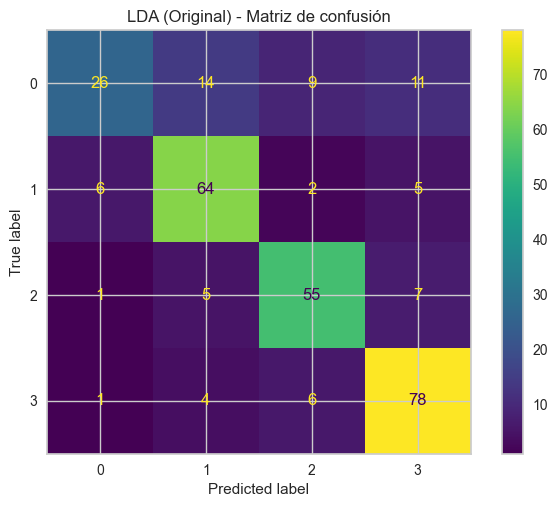

<Figure size 600x600 with 0 Axes>

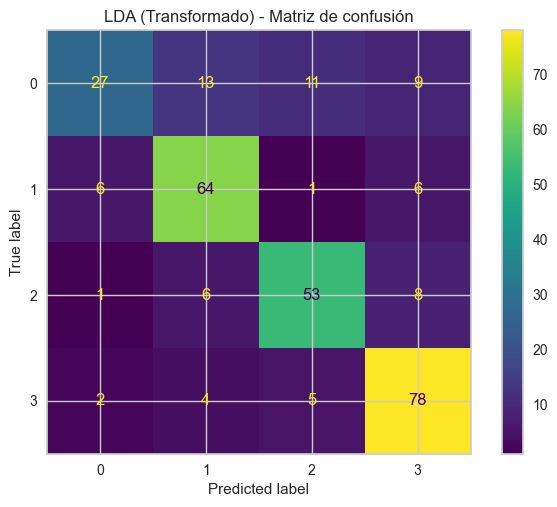

In [87]:
plt.figure(figsize=(6,6))
ConfusionMatrixDisplay.from_estimator(lda_model_orig, X_test_orig_s, y_test,)
plt.title("LDA (Original) - Matriz de confusión")
plt.show()

plt.figure(figsize=(6,6))
ConfusionMatrixDisplay.from_estimator(lda_model_trans, X_test_trans_s, y_test,)
plt.title("LDA (Transformado) - Matriz de confusión")
plt.show()

Las Confusion Matrix confirman que la gaussanización no altera el LDA. Ambos modelos tienen la misma accuracy y el mismo patrón de confusiones, teniendo como punto débil la clase 0, ya que las clases 1 y 3 están muy bien identificadas.

C:\Users\34656\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(


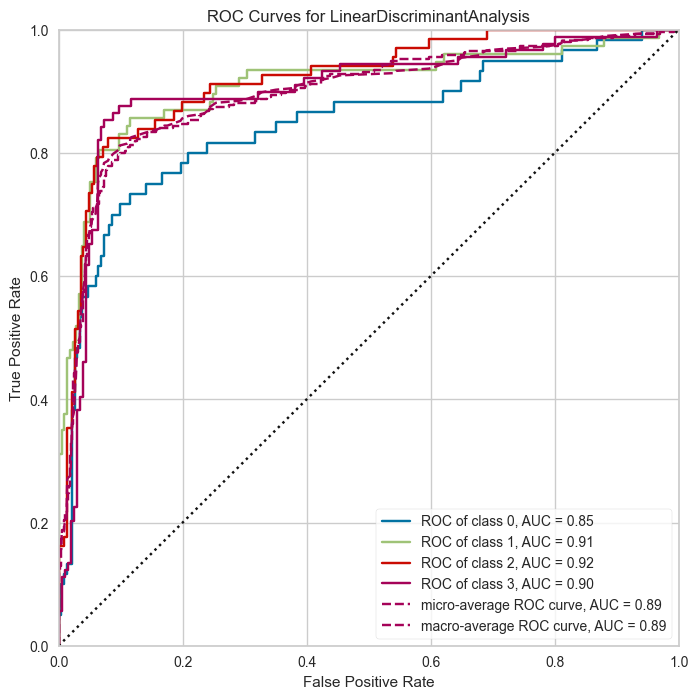

C:\Users\34656\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(


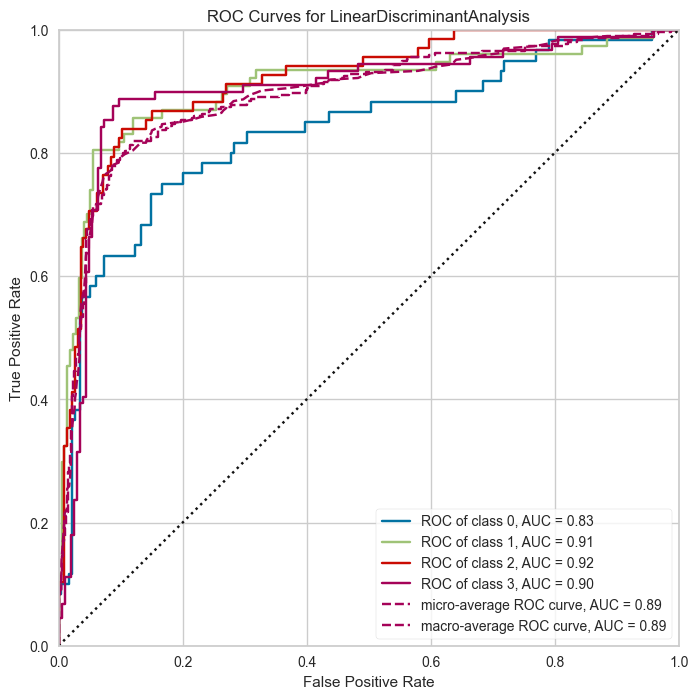

,estimator,LinearDiscrim...solver='lsqr')
,ax,<Axes: title=...ositive Rate'>
,micro,True
,macro,True
,per_class,True
,binary,False
,classes,"['0', '1', ...]"
,encoder,None
,is_fitted,'auto'
,force_model,False
,solver,'lsqr'


In [88]:
cls = [str(v) for v in sorted(pd.Series(y_train).unique())]

plt.figure(figsize=(8,8))
roc_auc(lda_model_orig, X_train_orig_s, y_train, X_test_orig_s, y_test, classes=cls)

plt.figure(figsize=(8,8))
roc_auc(lda_model_trans, X_train_trans_s, y_train, X_test_trans_s, y_test, classes=cls)

Ambas curvas ROC son similares y sólidas. AMbos modelos tienen un buen rendimiento, con un AUC micro y macro de aproximadamente 0.89, que como hemos dicho antes, la clase 0 es la que se podria decir que nos da más problemas, a pesar de ser esta bastante buena. En conclusión, la transformación apenas cambia el ranking de probabilidades en LDA, quedando en ocasiones incluso por delante el modelo original (en la clase 0), mientras que el desempeño global se mantiene equivalente a nivel macro/micro AUC.

## Concliones después de utilizar LDA
La exploración ha confirmado la correlación entre las variables, por lo que se rompe la hipótesis de Naïve Bayes de que cada atributo aporta información por separado. Al comparar con Naïve Bayes el modelo transformado mejoró claramente respecto al original, pero a su vez penalizó por la dependencia de atributos. En cambio, como LDA admite correlaciones, con nuestro best_param (sqr + shrinkage='auto') ha rendido de manera más estable en ambos conjuntos, por lo que se podría decir que apenas necesita la gaussanización.

# Apartado D

In [89]:
log_base_orig  = LogisticRegression(max_iter=10000, solver='saga', penalty='l2')
log_base_orig.best_score_  = np.mean(cross_val_score(log_base_orig,  X_train_orig_s,  y_train, cv=10))
print("Baseline CV (Original) Logistic:", log_base_orig.best_score_)

log_base_trans = LogisticRegression(max_iter=10000, solver='saga', penalty='l2')
log_base_trans.best_score_ = np.mean(cross_val_score(log_base_trans, X_train_trans_s, y_train, cv=10))
print("Baseline CV (Transformado) Logistic:", log_base_trans.best_score_)

Baseline CV (Original) Logistic: 0.7814578005115089
Baseline CV (Transformado) Logistic: 0.7697570332480818


In [90]:
Cs = 10**np.linspace(-3, 3, 21)
param_grid_log = {'penalty': ['l1', 'l2'], 'C': Cs}

grid_log_orig = GridSearchCV(
    LogisticRegression(max_iter=10000, solver='saga'),
    param_grid_log, cv=10, n_jobs=-1, refit=True
)
grid_log_orig.fit(X_train_orig_s, y_train)

grid_log_orig = GridSearchCV(LogisticRegression(max_iter=10000, solver='saga', multi_class='multinomial'), param_grid_log, cv=10, n_jobs=-1, refit=True)
grid_log_orig.fit(X_train_orig_s, y_train)
print("\nBest CV score (Original Logistic):", grid_log_orig.best_score_)
print("Best params (Original Logistic):", grid_log_orig.best_params_)

grid_log_trans = GridSearchCV(LogisticRegression(max_iter=10000, solver='saga', multi_class='multinomial'), param_grid_log, cv=10, n_jobs=-1, refit=True)
grid_log_trans.fit(X_train_trans_s, y_train)
print("\nBest CV score (Transformado Logistic):", grid_log_trans.best_score_)
print("Best params (Transformado Logistic):", grid_log_trans.best_params_)


Best CV score (Original Logistic): 0.7814578005115089
Best params (Original Logistic): {'C': np.float64(1.0), 'penalty': 'l1'}

Best CV score (Transformado Logistic): 0.7741474850809889
Best params (Transformado Logistic): {'C': np.float64(1.9952623149688788), 'penalty': 'l1'}


In [91]:
print("\nClassification report Logistic (Original)")
print(classification_report(y_test, log_model_orig.predict(X_test_orig_s)))
results_df = save_results(log_model_orig, X_test_orig_s, y_test, 'Logistic (orig)', results_df)

print("\nClassification report Logistic (Transformado)")
print(classification_report(y_test, log_model_trans.predict(X_test_trans_s)))
results_df = save_results(log_model_trans, X_test_trans_s, y_test, 'Logistic (trans)', results_df)


Classification report Logistic (Original)
              precision    recall  f1-score   support

           0       0.76      0.42      0.54        60
           1       0.68      0.84      0.76        77
           2       0.77      0.75      0.76        68
           3       0.77      0.87      0.81        89

    accuracy                           0.74       294
   macro avg       0.75      0.72      0.72       294
weighted avg       0.75      0.74      0.73       294


Classification report Logistic (Transformado)
              precision    recall  f1-score   support

           0       0.74      0.42      0.53        60
           1       0.68      0.84      0.76        77
           2       0.74      0.71      0.72        68
           3       0.76      0.85      0.80        89

    accuracy                           0.73       294
   macro avg       0.73      0.71      0.70       294
weighted avg       0.73      0.73      0.72       294



In [92]:
Cs = 10**np.linspace(-3, 3, 21)
param_grid_bal = {'penalty': ['l1', 'l2'], 'C': Cs}

grid_log_orig_bal = GridSearchCV(
    LogisticRegression(max_iter=10000, solver='saga', class_weight='balanced'),
    param_grid_bal, cv=10, n_jobs=-1, refit=True
)
grid_log_orig_bal.fit(X_train_orig_s, y_train)
print("Best CV (Logistic balanced - Original):", grid_log_orig_bal.best_score_)
print("Best params (Logistic balanced - Original):", grid_log_orig_bal.best_params_)

grid_log_trans_bal = GridSearchCV(
    LogisticRegression(max_iter=10000, solver='saga', class_weight='balanced'),
    param_grid_bal, cv=10, n_jobs=-1, refit=True
)
grid_log_trans_bal.fit(X_train_trans_s, y_train)
print("Best CV (Logistic balanced - Transformado):", grid_log_trans_bal.best_score_)
print("Best params (Logistic balanced - Transformado):", grid_log_trans_bal.best_params_)

Best CV (Logistic balanced - Original): 0.8178175618073317
Best params (Logistic balanced - Original): {'C': np.float64(0.12589254117941676), 'penalty': 'l1'}
Best CV (Logistic balanced - Transformado): 0.8046675191815856
Best params (Logistic balanced - Transformado): {'C': np.float64(0.12589254117941676), 'penalty': 'l1'}


In [99]:
log_model_orig_bal = LogisticRegression(max_iter=10000, solver='saga', class_weight='balanced',
                                        **grid_log_orig_bal.best_params_).fit(X_train_orig_s, y_train)
log_model_orig_bal.best_score_ = grid_log_orig_bal.best_score_

log_model_trans_bal = LogisticRegression(max_iter=10000, solver='saga', class_weight='balanced',
                                         **grid_log_trans_bal.best_params_).fit(X_train_trans_s, y_train)
log_model_trans_bal.best_score_ = grid_log_trans_bal.best_score_

print("\nClassification report Logistic balanced (Original)")
print(classification_report(y_test, log_model_orig_bal.predict(X_test_orig_s)))
results_df = save_results(log_model_orig_bal, X_test_orig_s, y_test, 'Logistic bal (orig)', results_df)

print("\nClassification report Logistic balanced (Transformado)")
print(classification_report(y_test, log_model_trans_bal.predict(X_test_trans_s)))
results_df = save_results(log_model_trans_bal, X_test_trans_s, y_test, 'Logistic bal (trans)', results_df)



Classification report Logistic balanced (Original)
              precision    recall  f1-score   support

           0       0.77      0.57      0.65        60
           1       0.73      0.86      0.79        77
           2       0.75      0.78      0.76        68
           3       0.82      0.81      0.81        89

    accuracy                           0.77       294
   macro avg       0.77      0.75      0.75       294
weighted avg       0.77      0.77      0.76       294


Classification report Logistic balanced (Transformado)
              precision    recall  f1-score   support

           0       0.70      0.52      0.60        60
           1       0.71      0.84      0.77        77
           2       0.73      0.75      0.74        68
           3       0.81      0.81      0.81        89

    accuracy                           0.74       294
   macro avg       0.74      0.73      0.73       294
weighted avg       0.74      0.74      0.74       294



En ambos conjuntos el modelo usa penalización L1, con C = 1.0 (original) y C = 2.0 (transformado). La regularización L1 sugiere que una solución escasa ayuda a manejar redundancias y correlaciones entre variables. También se puede ver que el conjunto original estandariza y rinde un poco mejor que el transformado. La regresión logística con L1 ofrece un buen desempeño y se destaca que el recall de la clase 0 se mantiene.

Dado el ligero desbalande y sobre todo la dificultad de la clase 0, vamos a pasar a reajustar la regresión logística pero con class_weight = 'balanced' para ponderar las clases automáticamente.
## Modelos regresión logística con class_weight = 'balanced'

<Figure size 600x600 with 0 Axes>

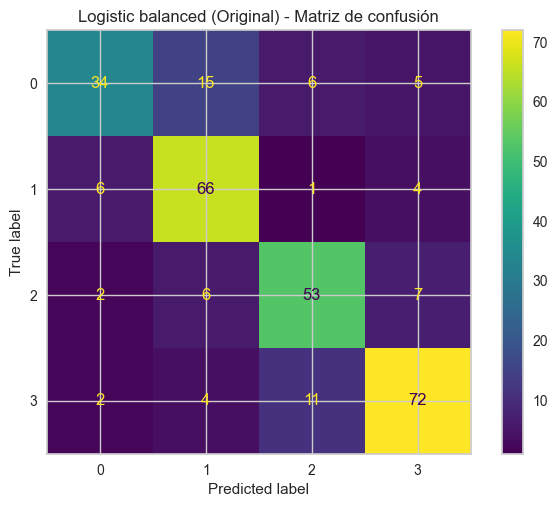

<Figure size 600x600 with 0 Axes>

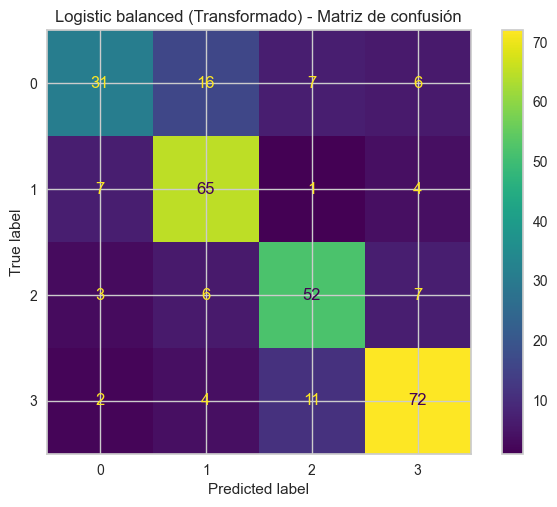

In [96]:
plt.figure(figsize=(6,6))
ConfusionMatrixDisplay.from_estimator(log_model_orig_bal, X_test_orig_s, y_test)
plt.title("Logistic balanced (Original) - Matriz de confusión")
plt.show()

plt.figure(figsize=(6,6))
ConfusionMatrixDisplay.from_estimator(log_model_trans_bal, X_test_trans_s, y_test)
plt.title("Logistic balanced (Transformado) - Matriz de confusión")
plt.show()

C:\Users\34656\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


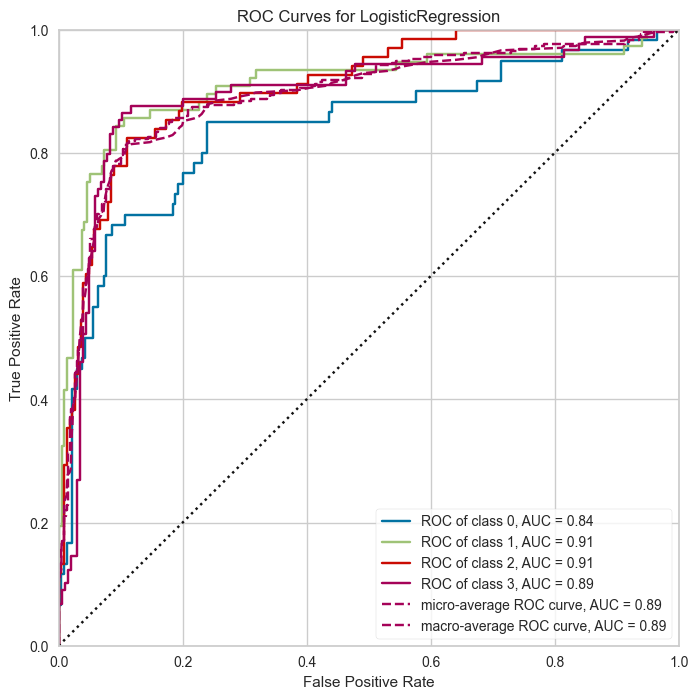

C:\Users\34656\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


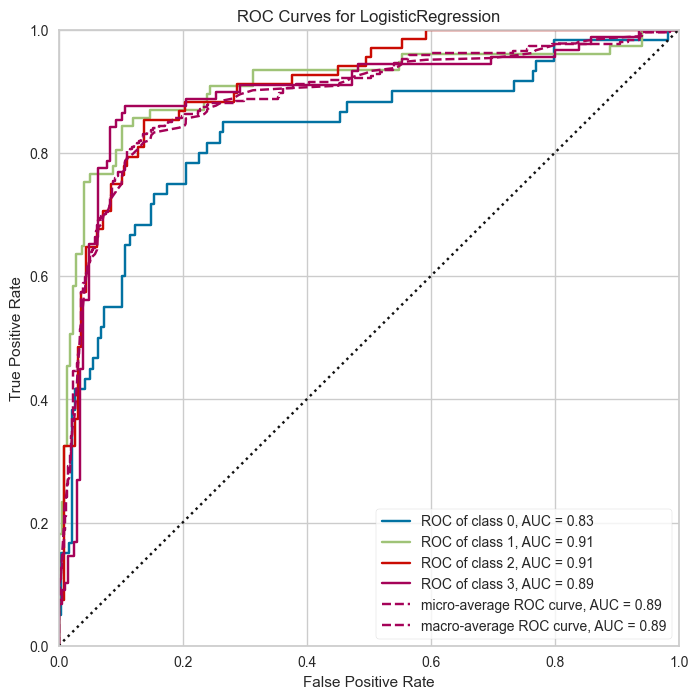

,estimator,LogisticRegre...solver='saga')
,ax,<Axes: title=...ositive Rate'>
,micro,True
,macro,True
,per_class,True
,binary,False
,classes,"['0', '1', ...]"
,encoder,None
,is_fitted,'auto'
,force_model,False
,penalty,'l1'


In [98]:
cls = [str(v) for v in sorted(pd.Series(y_train).unique())]
plt.figure(figsize=(8,8))
roc_auc(log_model_orig_bal, X_train_orig_s, y_train, X_test_orig_s, y_test, classes=cls)
plt.figure(figsize=(8,8))
roc_auc(log_model_trans_bal, X_train_trans_s, y_train, X_test_trans_s, y_test, classes=cls)

Con la neva regresión logística con el parámetro class_weight='balanced', ha tenido el efecto positivo esperado. El recall de la clase 0 aumenta de forma notoria. En el conjunto original, los aciertos de la clase 0 pasan de aprocumadamente el 42% a 57%, mientras que en el conjunto transformado sube hasta cerca del 52%. Esta ganancia se compensa con una ligera caída en las otras clases. 

Las curvas ROC confirman que el ranking de probabilidades casi ni cambia. Por lo que se podría decir que la ponderación reequilibra la decisión entre clases sin deteriorar la capacidad de ordenación del modelo.

## ¿Qué modelo elegirías de entre todos los que has obtenido? ¿Por qué?
Con estos resultados, elegiría como modelo final la regresión logística con class_weight='balanced' entrenada sobre el conjunto original. Es la que mejor corrige el principal pinto débil observado, que era la clase 0, manteniendo un rendimiento global muy sólido y conservando un AUC macro/micro elevado. La versión balanced con los datos transformados también mejora bastante, pero obtiene resultados un poco peores. 

Para analizar los pesos del mejor modelo se va a ordenar los coeficientes por su valor absoluto y comentar los atributos que más importancia tienen y los que menos sobre una clase, los cuales son los encargados de separar las clases. 

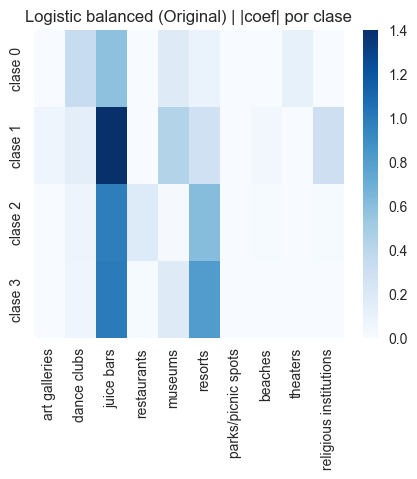


Clase 0 — Top 8 pesos POSITIVOS (empujan hacia la clase):
theaters                 -0.112401
resorts                  -0.088322
parks/picnic spots        0.000000
restaurants               0.000000
beaches                   0.000000
art galleries             0.000000
religious institutions    0.000000
juice bars                0.580569
Name: clase 0, dtype: float64

Clase 0 — Top 8 pesos NEGATIVOS (empujan fuera de la clase):
dance clubs          -0.343919
museums              -0.176155
theaters             -0.112401
resorts              -0.088322
parks/picnic spots    0.000000
restaurants           0.000000
beaches               0.000000
art galleries         0.000000
Name: clase 0, dtype: float64

Clase 1 — Top 8 pesos POSITIVOS (empujan hacia la clase):
parks/picnic spots    0.000000
restaurants           0.000000
theaters              0.000000
art galleries         0.069473
dance clubs           0.137129
resorts               0.289247
museums               0.437832
juice bars     

In [100]:
best_log_model = log_model_orig_bal
feature_names = getattr(X_train, "columns", None)

coefs = pd.DataFrame(best_log_model.coef_,  index=[f"clase {c}" for c in best_log_model.classes_], columns=feature_names if feature_names is not None else [f"x{i}" for i in range(best_log_model.coef_.shape[1])])

plt.figure(figsize=(min(18, 1 + 0.4*coefs.shape[1]), 2 + 0.5*coefs.shape[0]))
sns.heatmap(coefs.abs(), cmap="Blues", cbar=True)
plt.title("Logistic balanced (Original) | |coef| por clase")
plt.show()

topk = 8
for i, c in enumerate(best_log_model.classes_):
    s = coefs.iloc[i].sort_values()
    print(f"\nClase {c} — Top {topk} pesos POSITIVOS (empujan hacia la clase):")
    print(s.tail(topk))
    print(f"\nClase {c} — Top {topk} pesos NEGATIVOS (empujan fuera de la clase):")
    print(s.head(topk))

## Conclusiones finales - Separación de clases
Podemos ver que claramente “juice bars” es el atributo con más relevancia del conjunto, con un peso muy alto y positivo para las clases 1 y 0 y fuertemente negativo para las clases 2 y 3. Esto nos sugiere que en la práctica su presencia empuja con fuerza hacia la clase 1 frente a las demás y en menor medida hacia la 0.

La categoria "resorts" tiene también fuerza tanto en la clase 2 (positivamente) como en la 3 (negativamente. "Museums" tiene algo de peso positivo en la clase 1. Por último se destaca categorias como “theaters”,“beaches”, "parks/picnic spots” y “art galleries”, que tienen efectos prácticamente inexistentes en la separación de clases (pesos muy cercanos a 0 o incluso exactamente 0 en todas las clases). 

Si recordamos que cada atributo es una valoración entre 0 y 4 (obviamente antes de estandarizar las variables), estos pesos nos indica cómo cambia la probabilidad de pertenecer a cada clase cuando aumentamos en una desviación típica la puntuación de un atributo. Por ejemplo, el gran peso positivo de “juice bars” se traduce en que las personas de la clase 1 tienden a puntuar muy alto este atributo, mientras que los que pertenecen a la clase 2 y 3 lo puntúan bajo. Estos cambios de valoraciones en una misma categoria hace que se separen la clase 1 con la clase 2 y 3. DE la misma manera pasa con la categoria "resorts" (coeficiente positivo en la clase 2 y negativo en la clase 3) indica que los integrantes de la clase 2 suelen dar puntuaciones altas en esta categoria y bajas los de la clase 3.

Que “theaters”, “beaches”, “parks/picnic spots” y “art galleries” tengan coeficientes casi nulos, encaja con la idea de que sus valoraciones están muy igualadas entre clases. Es decir, que el promedio de todas las clases los puntúan de forma parecida. Estas categorias ayudan poco a distinguir perfiles porque no generan diferencias entre clases.